## Ejemplo de Clasificación

Vamos a ver ahora un ejemplo de clasificación de imagen utilizando `redes neuronales`. Cómo ya hemos comentado anteriormente, tienes muchos ejemplos de esta tarea en posts anteriores. Aquí vamos a ver cómo clasificar imágenes con el dataset EMNIST letras utilizando `Pytorch`. 

En primer lugar vamos a descargar el dataset utilizando la librería `torchvision`, que nos ofrece datasets, modelos, transformaciones y operaciones comunes en el campo de la visión artificial.

In [ ]:
import torch
import torchvision

dataset = {
    'train': torchvision.datasets.EMNIST('./data',split="letters" , train=True, download=True, transform=torchvision.transforms.ToTensor()),
    'test': torchvision.datasets.EMNIST('./data',split="letters" , train=False, download=True, transform=torchvision.transforms.ToTensor())
}

len(dataset['train']), len(dataset['test'])

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


(124800, 20800)

En cualquier tarea de visión artificial es recomendable visualizar ejemplos de imágenes en el dataset para hacernos una idea del tipo de datos con el que trabajamos y las diferentes categorías.

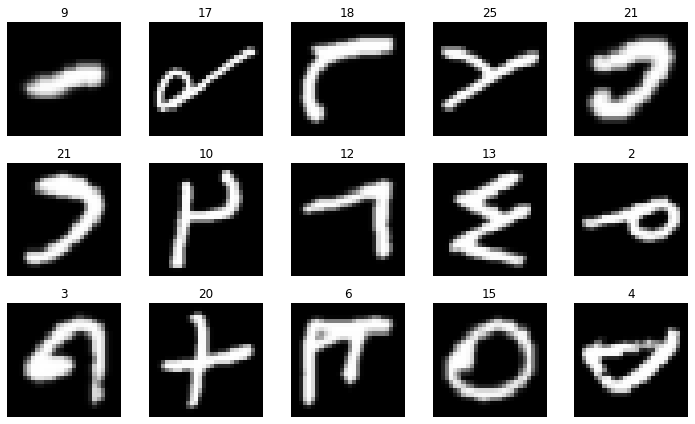

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(label)
plt.tight_layout()
plt.show()

In [ ]:
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 28, 28]), torch.float32, tensor(1.), tensor(0.))

Como puedes ver tenemos imágenes de dígitos manuscritos, y el objetivo es el da asignar una etiqueta a cada imagen que corresponda con el dígito presente en ella. Esto lo conseguimos haciendo que nuestra red neuronal nos de 10 valores a la salida, que representa una distribución de probabilidad sobre todas las clases. Dada una imagen, le asignaremos la etiqueta correspondiente al valor más grande a la salida.

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=27):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [ ]:
model = CNN()
output = model(torch.randn(64, 1, 28, 28))
output.shape

torch.Size([64, 27])

> 💡 En posts anteriores hemos hablado en detalle sobre `redes neuronales convolucionales`, así que si no entiendes bien lo que estamos haciendo en el modelo anterior te recomendamos que les eches un vistazo.

In [ ]:
from tqdm import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=1):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 1, 28, 28])

In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 0.28264 val_acc 0.91221: 100%|██████████| 325/325 [00:19<00:00, 16.67it/s]

Epoch 1/1 loss 0.41958 val_loss 0.28264 acc 0.87099 val_acc 0.91221


In [ ]:
x = torch.rand(64, 1, 28, 28)
y = model.cpu()(x)

# exportamos el modelo
torch.onnx.export(model,                     # el modelo
                  x,                         # un ejemplo del input
                  "model.onnx",              # el nombre del archivo para guardar el modelo
                  export_params=True,        # guardar los pesos de la red
                  opset_version=10,          # versión de ONNX
                  do_constant_folding=True,  # optimizaciones
                  input_names = ['input'],   # nombre de los inputs
                  output_names = ['output'], # nombre de los outputs
                  dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                'output' : {0 : 'batch_size'}})

In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.5 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 


In [ ]:
import onnxruntime

def onnx_evaluate(model, dataloader): 
    # cargarmos el modelo
    ort_session = onnxruntime.InferenceSession(model)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.numpy(), y.numpy()
            # generamos los inputs
            ort_inputs = {ort_session.get_inputs()[0].name: X}
            # extraemos los outputs
            ort_outs = ort_session.run(None, ort_inputs)[0]
            acc.append((y == np.argmax(ort_outs, axis=1)).mean())
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [ ]:
onnx_evaluate("model.onnx", dataloader)

acc 0.91221: 100%|██████████| 325/325 [00:16<00:00, 19.75it/s]


Una vez nuestro modelo ha sido entrenado podemos utilizarlo para generar predicciones en los datos de test (no vistos durante el entrenamiento) y evaluar los puntos débiles de nuestro modelo.

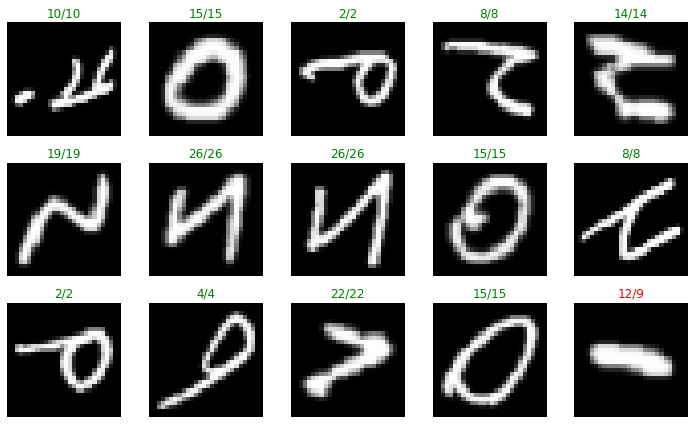

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['test'])-1)
        img, label = dataset['test'][ix]
        preds = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(preds, axis=1)[0].item()
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.axis("off")
        plt.title(f'{label}/{pred}', color = "red" if label != pred else "green")
plt.tight_layout()
plt.show()